Install the dependencies

In [68]:
import numpy as np
import pandas as pd
import pandas_ta as ta # pandas technical analysis
import pandas_datareader.data as web
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime

import yfinance as yf # as a means to access yahoo finance data

from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

from sklearn.svm import SVC # svm
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, accuracy_score
from sklearn.model_selection import GridSearchCV # c, gamma parameter optimisation

# customising matplotlib with style sheets and rcParams
# global change, for only temporary change use "with"
# rc stands for run commands
plt.style.use("classic") # plt.style.available[:] gives list of all available stylesheets
plt.rcParams["font.size"] = 11
plt.rcParams["lines.linestyle"] = "-"
# plt.rcParams["figure.dpi"] = 500 #sharp image

import warnings # ignore warnings
warnings.filterwarnings('ignore')

from IPython.display import display # display all columns
pd.options.display.max_columns = None

In [62]:
end = datetime.today()
start = datetime(end.year-2, end.month, end.day)

list_of_tickers = ["^GSPC", "^IXIC", "^N225"] # add tickers here
d = web.DataReader(list_of_tickers, 'yahoo', start, end)

In [3]:
d

Attributes    Adj Close                                    Close  \
Symbols           ^GSPC         ^IXIC         ^N225        ^GSPC   
Date                                                               
2019-09-02          NaN           NaN  20620.189453          NaN   
2019-09-03  2906.270020   7874.160156  20625.160156  2906.270020   
2019-09-04  2937.780029   7976.879883  20649.140625  2937.780029   
2019-09-05  2976.000000   8116.830078  21085.939453  2976.000000   
2019-09-06  2978.709961   8103.069824  21199.570312  2978.709961   
...                 ...           ...           ...          ...   
2021-08-26  4470.000000  14945.809570  27742.289062  4470.000000   
2021-08-27  4509.370117  15129.500000  27641.140625  4509.370117   
2021-08-30  4528.790039  15265.889648  27789.289062  4528.790039   
2021-08-31  4522.680176  15259.240234  28089.539062  4522.680176   
2021-09-01          NaN           NaN  28451.019531          NaN   

Attributes                                     High                \
Symbols            ^IXIC         ^N225        ^GSPC         ^IXIC   
Date                                                                
2019-09-02           NaN  20620.189453          NaN           NaN   
2019-09-03   7874.160156  20625.160156  2914.389893   7940.370117   
2019-09-04   7976.879883  20649.140625  2938.840088   7981.410156   
2019-09-05   8116.830078  21085.939453  2985.860107   8134.419922   
2019-09-06   8103.069824  21199.570312  2985.030029   8134.390137   
...                  ...           ...          ...           ...   
2021-08-26  14945.809570  27742.289062  4495.899902  15059.629883   
2021-08-27  15129.500000  27641.140625  4513.330078  15144.480469   
2021-08-30  15265.889648  27789.289062  4537.359863  15288.080078   
2021-08-31  15259.240234  28089.539062  4531.390137  15278.959961   
2021-09-01           NaN  28451.019531          NaN           NaN   

Attributes                        Low                              \
Symbols            ^N225        ^GSPC         ^IXIC         ^N225   
Date                                                                
2019-09-02  20667.560547          NaN           NaN  20614.289062   
2019-09-03  20662.230469  2891.850098   7847.319824  20578.019531   
2019-09-04  20694.349609  2921.860107   7928.939941  20554.160156   
2019-09-05  21164.609375  2960.600098   8061.290039  20787.929688   
2019-09-06  21241.289062  2972.510010   8098.520020  21145.810547   
...                  ...          ...           ...           ...   
2021-08-26  27828.279297  4468.990234  14939.559570  27684.500000   
2021-08-27  27670.660156  4474.100098  14966.519531  27481.230469   
2021-08-30  27921.550781  4513.759766  15165.120117  27656.630859   
2021-08-31  28158.949219  4515.799805  15202.669922  27602.210938   
2021-09-01  28457.669922          NaN           NaN  28179.039062   

Attributes         Open                                    Volume  \
Symbols           ^GSPC         ^IXIC         ^N225         ^GSPC   
Date                                                                
2019-09-02          NaN           NaN  20625.750000           NaN   
2019-09-03  2909.010010   7906.439941  20581.580078  3.426790e+09   
2019-09-04  2924.669922   7949.810059  20578.669922  3.163260e+09   
2019-09-05  2960.600098   8061.290039  20800.289062  3.890700e+09   
2019-09-06  2980.330078   8125.580078  21201.830078  3.208280e+09   
...                 ...           ...           ...           ...   
2021-08-26  4493.750000  15025.169922  27793.630859  2.704600e+09   
2021-08-27  4474.100098  14969.769531  27581.240234  2.862360e+09   
2021-08-30  4513.759766  15165.940430  27867.599609  2.557300e+09   
2021-08-31  4529.750000  15262.879883  27690.769531  3.090380e+09   
2021-09-01          NaN           NaN  28179.039062           NaN   

Attributes                            
Symbols            ^IXIC       ^N225  
Date                                  
2019-09-02           NaN  424

In [4]:
# .stack() converts the innermost column index into the innermost row index
t = d.stack() # https://medium.com/swlh/reshaping-in-pandas-with-stack-and-unstack-functions-bb169f64467d
t = t.reset_index() # not necessary, puts the same date to each innermost row index
t

Attributes,Date,Symbols,Adj Close,Close,High,Low,Open,Volume
0,2019-09-02,^N225,20620.189453,20620.189453,20667.560547,20614.289062,20625.750000,4.240000e+07
1,2019-09-03,^GSPC,2906.270020,2906.270020,2914.389893,2891.850098,2909.010010,3.426790e+09
2,2019-09-03,^IXIC,7874.160156,7874.160156,7940.370117,7847.319824,7906.439941,1.936210e+09
3,2019-09-03,^N225,20625.160156,20625.160156,20662.230469,20578.019531,20581.580078,0.000000e+00
4,2019-09-04,^GSPC,2937.780029,2937.780029,2938.840088,2921.860107,2924.669922,3.163260e+09
...,...,...,...,...,...,...,...,...
1489,2021-08-30,^N225,27789.289062,27789.289062,27921.550781,27656.630859,27867.599609,5.860000e+07
1490,2021-08-31,^GSPC,4522.680176,4522.680176,4531.390137,4515.799805,4529.750000,3.090380e+09
1491,2021-08-31,^IXIC,15259.240234,15259.240234,15278.959961,15202.669922,15262.879883,4.170170e+09
1492,2021-08-31,^N225,28089.539062,28089.539062,28158.949219,27602.210938,27690.769531,7.590000e+07


In [5]:
gspc = t[t["Symbols"] == "^GSPC"]
ixic = t[t["Symbols"] == "^IXIC"]
n225 = t[t["Symbols"] == "^N225"]
list_of_assets = [gspc, ixic, n225]

In [6]:
for asset in list_of_assets:
    asset["RoC"] = ((asset["Adj Close"] - asset["Adj Close"].shift(1))/asset["Adj Close"].shift(1))*100

In [7]:
days = [5,10,20] # last week, last two weeks, last month

for i in days:
    for asset in list_of_assets:
        column_name = f"MA for {i} days"
        asset[column_name] = asset["Adj Close"].rolling(window=i).mean()

In [8]:
# bollinger bands
def boll(closing, length, num_sd):
    """
    returns average, upper band, lower band
    """
    av = closing.rolling(window=length).mean()
    sd = closing.rolling(window=length).std()
    up = av + (num_sd*sd)
    down = av - (num_sd*sd)
    return np.round(down,6), np.round(av,6), np.round(up,6)

In [9]:
length = 50
num_sd = 2

down = f"Lower band"
av = f"Middle band"
up = f"Upper band"

for asset in list_of_assets:
    asset[down], asset[av], asset[up] = boll(asset["Adj Close"], 
                                             length=length, 
                                             num_sd=num_sd
                                            )

In [10]:
# rsi & momentum
def rsi(values):
    up = values[values>0].mean()
    down = -1*values[values<0].mean()
    return 100*up / (up + down)

window = 14

for asset in list_of_assets:
    asset["Momentum_1D"] = asset["Adj Close"] - asset["Adj Close"].shift(1)
    asset["RSI_14D"] = asset["Momentum_1D"].rolling(window=window).apply(rsi)

In [11]:
# macd
for asset in list_of_assets:
    asset["EWMA_26D"] = asset["Adj Close"].ewm(span=26).mean()
    asset["EWMA_12D"] = asset["Adj Close"].ewm(span=12).mean()
    asset["MACD"] = asset["EWMA_12D"] - asset["EWMA_26D"]

In [12]:
# stochastic oscillator (%K and %D)
def stoch_osci(asset, n=10):
    """
    returns the value for stochastic oscillator (%K and %D)
    """
    asset["Stoch Osci %K/%D"] = ((asset["Close"]                                 
                                  - asset["Low"].rolling(window=n).mean()
                                 ) /                                 
                                 (asset["High"].rolling(window=n).max()
                                  - asset["Low"].rolling(window=n).min()
                                 )
                                ) * 100

for asset in list_of_assets:
    stoch_osci(asset)

In [13]:
# william's %R
def willR(asset):
    h = asset["High"].rolling(window=window, center=False).max()
    l = asset["Low"].rolling(window=window, center=False).min()
    asset["Williams %R"] = -100*((h - asset["Adj Close"])/(h - l))

for asset in list_of_assets:
    willR(asset)

In [14]:
# aaron oscillator
def a(data, tp = 25):
    u = []
    d = []
    x = tp
    while x < len(asset["Date"]):
        u_ = ((asset["High"][x-tp:x].tolist().index(max(asset["High"][x-tp:x])))/float(tp))*100
        d_ = ((asset["Low"][x-tp:x].to_list().index(max(asset["Low"][x-tp:x])))/float(tp))*100
        u.append(u_)
        d.append(d_)
        x+=1
    return u,d

In [15]:
for asset in list_of_assets:
    zeros = [0] * 25
    up, down = a(asset)
    a_list = [a - b for a,b in zip(up, down)]
    if len(a_list) == 0:
        a_list = [0] * asset.shape[0]
        asset["Aroon Oscillator"] = a_list
    else:
        asset["Aroon Oscillator"] = zeros + a_list

In [16]:
def direction(x):
    if x>0:
        return 1.0
    else:
        return 0.0

for asset in list_of_assets:
    asset["Direction"] = asset["RoC"].apply(direction)

In [17]:
gspc.dtypes # all columns are float64

Attributes
Date                datetime64[ns]
Symbols                     object
Adj Close                  float64
Close                      float64
High                       float64
Low                        float64
Open                       float64
Volume                     float64
RoC                        float64
MA for 5 days              float64
MA for 10 days             float64
MA for 20 days             float64
Lower band                 float64
Middle band                float64
Upper band                 float64
Momentum_1D                float64
RSI_14D                    float64
EWMA_26D                   float64
EWMA_12D                   float64
MACD                       float64
Stoch Osci %K/%D           float64
Williams %R                float64
Aroon Oscillator           float64
Direction                  float64
dtype: object

In [18]:
ixic

Attributes,Date,Symbols,Adj Close,Close,High,Low,Open,Volume,RoC,MA for 5 days,MA for 10 days,MA for 20 days,Lower band,Middle band,Upper band,Momentum_1D,RSI_14D,EWMA_26D,EWMA_12D,MACD,Stoch Osci %K/%D,Williams %R,Aroon Oscillator,Direction
2,2019-09-03,^IXIC,7874.160156,7874.160156,7940.370117,7847.319824,7906.439941,1.936210e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7874.160156,7874.160156,0.000000,NaN,NaN,0.0,0.0
5,2019-09-04,^IXIC,7976.879883,7976.879883,7981.410156,7928.939941,7949.810059,1.891300e+09,1.304517,NaN,NaN,NaN,NaN,NaN,NaN,102.719727,NaN,7927.495399,7929.800008,2.304609,NaN,NaN,0.0,1.0
8,2019-09-05,^IXIC,8116.830078,8116.830078,8134.419922,8061.290039,8061.290039,2.096300e+09,1.754448,NaN,NaN,NaN,NaN,NaN,NaN,139.950195,NaN,7995.521511,8002.797888,7.276377,NaN,NaN,0.0,1.0
11,2019-09-06,^IXIC,8103.069824,8103.069824,8134.390137,8098.520020,8125.580078,1.876380e+09,-0.169527,NaN,NaN,NaN,NaN,NaN,NaN,-13.760254,NaN,8025.587319,8034.449819,8.862500,NaN,NaN,0.0,0.0
14,2019-09-09,^IXIC,8087.439941,8087.439941,8131.660156,8052.339844,8130.910156,2.172240e+09,-0.192888,8031.675977,NaN,NaN,NaN,NaN,NaN,-15.629883,NaN,8039.931198,8048.847046,8.915849,NaN,NaN,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1479,2021-08-25,^IXIC,15041.860352,15041.860352,15059.429688,15011.580078,15039.030273,3.629990e+09,0.146876,14852.152148,14787.577051,14784.694482,14141.091479,14616.485195,15091.878912,22.060547,49.844860,14740.721467,14822.042323,81.320856,54.952390,-2.761304,0.0,1.0
1482,2021-08-26,^IXIC,14945.809570,14945.809570,15059.629883,14939.559570,15025.169922,3.610970e+09,-0.638557,14932.956055,14800.532031,14793.071973,14180.347367,14634.607793,15088.868219,-96.050781,47.892400,14755.913178,14841.083438,85.170259,36.063399,-17.883068,0.0,0.0
1485,2021-08-27,^IXIC,15129.500000,15129.500000,15144.480469,14966.519531,14969.769531,4.006310e+09,1.229043,15015.924023,14831.191992,14815.912988,14199.512861,14653.970801,15108.428741,183.690430,53.785983,14783.586276,14885.455216,101.868940,54.939957,-2.076812,4.0,1.0
1488,2021-08-30,^IXIC,15265.889648,15265.889648,15288.080078,15165.120117,15165.940430,4.034110e+09,0.901482,15080.571875,14878.404980,14845.153955,14228.278311,14678.680996,15129.083681,136.389648,54.414009,14819.312452,14943.983591,124.671139,55.169576,-2.565605,8.0,1.0


In [19]:
gspc.fillna("-", axis=1, inplace=True) # once I put "-" it converts data type from float64 into object
ixic.fillna("-", axis=1, inplace=True) # put this at very end so that I can work with float64
gspc

Attributes,Date,Symbols,Adj Close,Close,High,Low,Open,Volume,RoC,MA for 5 days,MA for 10 days,MA for 20 days,Lower band,Middle band,Upper band,Momentum_1D,RSI_14D,EWMA_26D,EWMA_12D,MACD,Stoch Osci %K/%D,Williams %R,Aroon Oscillator,Direction
1,2019-09-03,^GSPC,2906.270020,2906.270020,2914.389893,2891.850098,2909.010010,3.426790e+09,-,-,-,-,-,-,-,-,-,2906.270020,2906.270020,0.000000,-,-,0.0,0.0
4,2019-09-04,^GSPC,2937.780029,2937.780029,2938.840088,2921.860107,2924.669922,3.163260e+09,1.08421,-,-,-,-,-,-,31.51,-,2922.630986,2923.337941,0.706955,-,-,0.0,1.0
7,2019-09-05,^GSPC,2976.000000,2976.000000,2985.860107,2960.600098,2960.600098,3.890700e+09,1.30098,-,-,-,-,-,-,38.22,-,2941.805955,2943.891955,2.086000,-,-,0.0,1.0
10,2019-09-06,^GSPC,2978.709961,2978.709961,2985.030029,2972.510010,2980.330078,3.208280e+09,0.0910605,-,-,-,-,-,-,2.70996,-,2952.122702,2954.882639,2.759937,-,-,0.0,1.0
13,2019-09-09,^GSPC,2978.429932,2978.429932,2989.429932,2969.389893,2988.429932,4.002890e+09,-0.00940103,2955.44,-,-,-,-,-,-0.280029,-,2958.223457,2961.280354,3.056897,-,-,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1478,2021-08-25,^GSPC,4496.189941,4496.189941,4501.709961,4485.660156,4490.450195,2.554680e+09,0.222012,4461.88,4455.95,4438.2,4206.47,4366.8,4527.13,9.95996,33.812,4423.329266,4453.288318,29.959052,46.2218,-4.12003,0.0,1.0
1481,2021-08-26,^GSPC,4470.000000,4470.000000,4495.899902,4468.990234,4493.750000,2.704600e+09,-0.582492,4474.72,4456.87,4440.74,4214.23,4371.72,4529.22,-26.1899,34.6397,4426.786358,4455.859346,29.072989,24.2088,-23.6677,0.0,0.0
1484,2021-08-27,^GSPC,4509.370117,4509.370117,4513.330078,4474.100098,4474.100098,2.862360e+09,0.880763,4488.26,4461.01,4446.45,4221.32,4377.47,4533.62,39.3701,32.6692,4432.903673,4464.091772,31.188099,48.4046,-2.71975,0.0,1.0
1487,2021-08-30,^GSPC,4528.790039,4528.790039,4537.359863,4513.759766,4513.759766,2.557300e+09,0.430657,4498.12,4466.59,4453.53,4235.04,4384.72,4534.39,19.4199,34.4967,4440.006367,4474.045352,34.038985,48.5098,-5.05207,8.0,1.0


In [20]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'tableau-colorblind10']

In [100]:
def p_twinx():
    fig, ax = plt.subplots(1,1,figsize=(15,5), constrained_layout=True)
    ax.plot(gspc["Date"], gspc["Adj Close"], color="blue")
    ax.set(title="^GSPC")

    ax2 = ax.twinx()
    ax2.plot(ixic["Date"], ixic["Adj Close"], color="red")

    ax.tick_params("y", colors="blue")
    ax2.tick_params("y", colors="red")

In [101]:
# def p():
#     fig, (ax1, ax2, ax3) = plt.subplots(3,1,figsize=(15,10), constrained_layout=True)
#     ax1.plot(gspc["Date"], gspc["Adj Close"], color="blue")
#     ax1.set(title="^GSPC")
    
#     ax2.plot(ixic["Date"], ixic["Adj Close"])
#     ax2.set(title="^IXIC")
    
#     ax3.plot(n225["Date"], n225["Adj Close"])
#     ax3.set(title="^N225")

#     fig.tight_layout(h_pad=2)

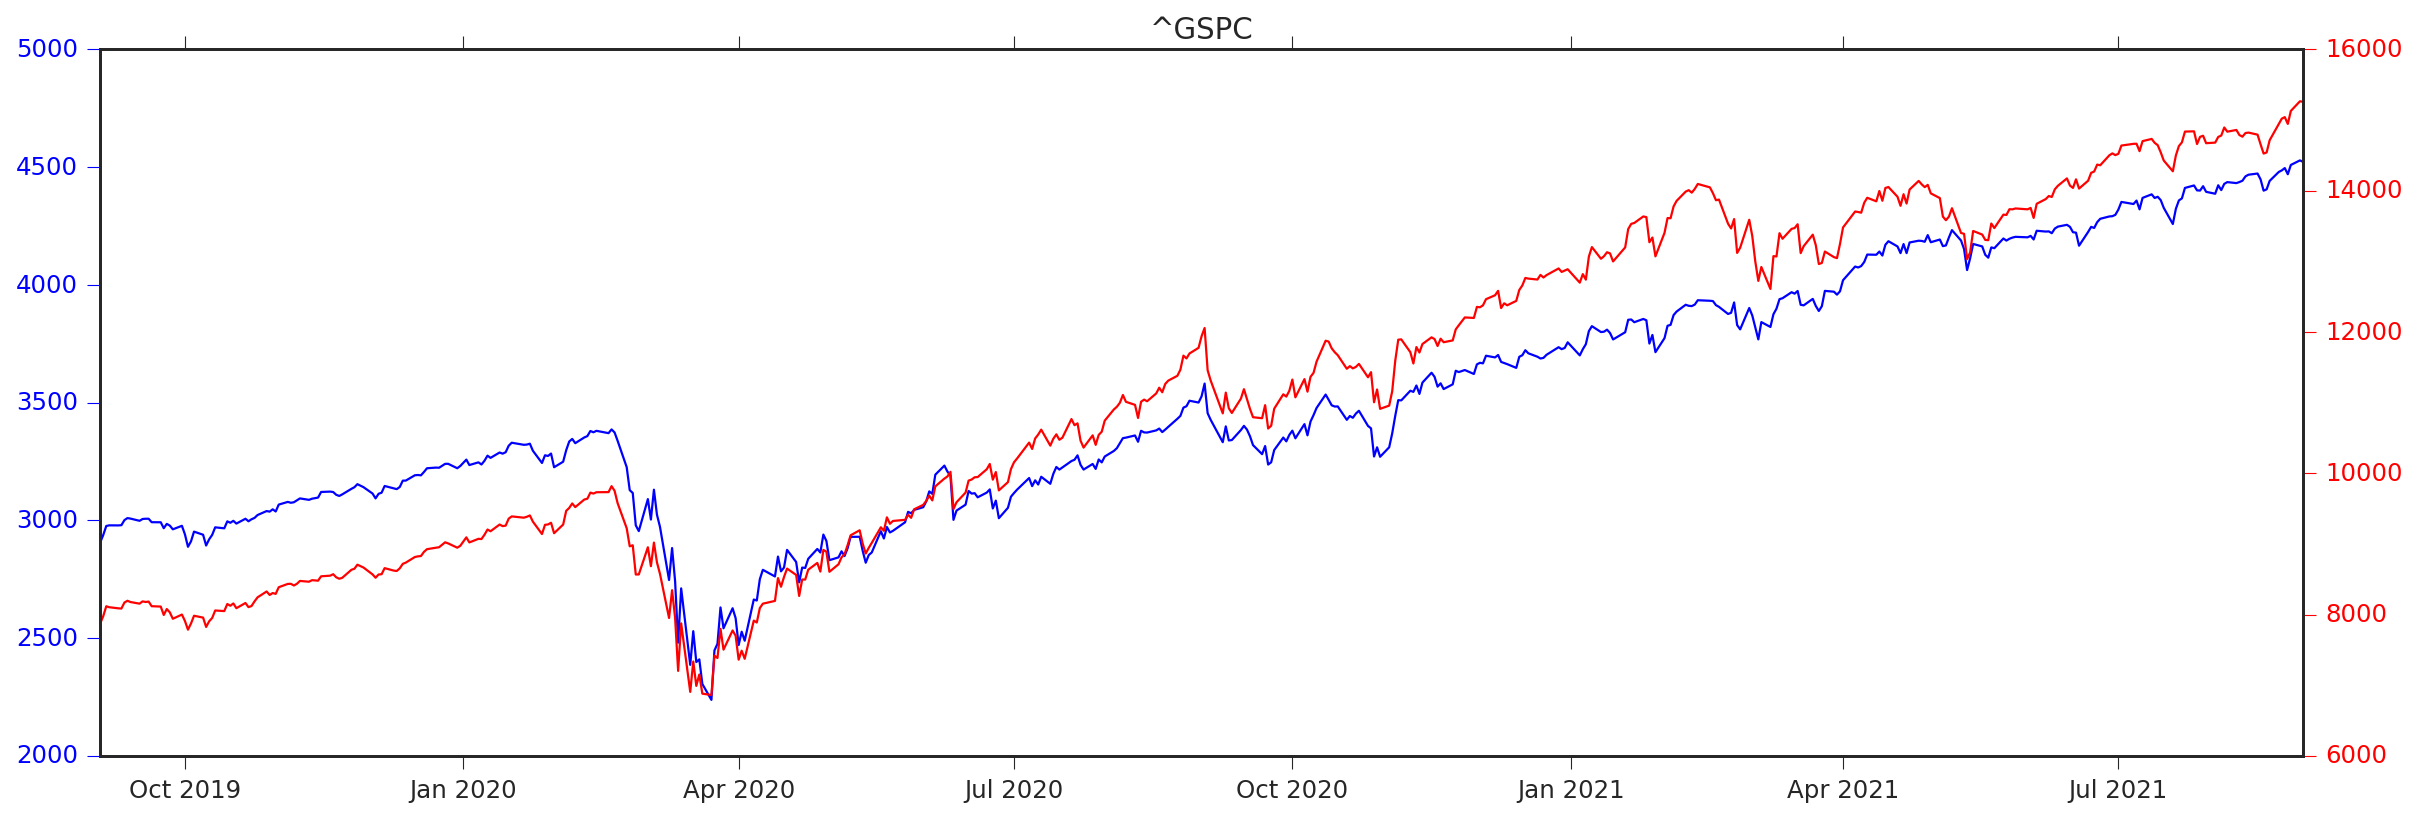

In [102]:
# used for local change only, rcParams used for global change
with plt.style.context("seaborn-ticks"):
    p_twinx()

In [25]:
# # high c/high gamma overfitting
# # low c/low gamma underfitting

# # data pre-processing
# X = df.iloc[:,0:5]
# y = df.iloc[:,-1]

# # MinMaxScaler
# scaler = MinMaxScaler()
# df = scaler.fit_transform(df)

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# X_train = np.array(X_train)
# y_train = np.array(y_train)
# X_test = np.array(X_test)
# y_test = np.array(y_test)

# # train the model
# svm = SVC(C=1.0, kernel="linear", gamma="scale")
# svm.fit(X_train, y_train)

# # prediction
# pred = svm.predict(X_test)
# pred

# # classification report and confusion matrix

# print("Classification report:")
# print(classification_report(y_test, pred))

# print("Confusion Matrix:")
# print(confusion_matrix(y_test, pred))

# print("Accuracy score:")
# print(accuracy_score(y_test, pred).round(2))

In [ ]:
# low gamma considers further away points to fit a hyperplane
# high gamma considers only close points to fit a hyperplane (prone to overfitting)
# too much emphasis on close points and not much on further away points - high gamma

# gridsearchcv
# param_grid = {"C":[0.1,1,10,100,1000], "gamma":[1,0.1,0.01,0.001], "kernel":["rbf", "poly", "sigmoid"]}
# svm_grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=2)
# # verbose just shows how much of text output during calculation to display

# svm_grid.fit(X_train, y_train)
# svm_grid.best_params_

In [ ]:
# # prediction with gridsearchcv (then classification report/confusion matrix)/accuracy score
# svm_grid_pred = svm_grid.predict(X_test)

# print("Classification report:")
# print(classification_report(y_test, svm_grid_pred))

# print("Confusion Matrix:")
# print(confusion_matrix(y_test, svm_grid_pred))

# print("Accuracy score:")
# print(accuracy_score(y_test, svm_grid_pred).round(2))